In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import random

import pandas as pd
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
from PIL import Image

from efficientnet_pytorch import EfficientNet

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import confusion_matrix

import albumentations as A

import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger(__name__)
import hashlib

In [2]:
emory = pd.read_csv('emory_final.csv')
vini = pd.read_csv('vinidir_final.csv')

In [3]:
vini = vini.rename(columns={'image_paths':'image_path'})
emory = emory.rename(columns={'Image_Paths':'image_path'})

In [4]:
emory['image_path'] = emory['image_path'].str.replace(r'^../', '', regex=True)

In [5]:
vini['patient_id'] = vini['image_path'].apply(lambda x: x.split('/')[2])
emory['patient_id'] = emory['image_path'].apply(lambda x:x.split('/')[2])

In [6]:
emory_f = emory[(emory['asses']!='BIRADS 0') & (emory['asses']!='BIRADS 6')].reset_index(drop=True)

emory_f['asses'] = emory_f['asses'].str.replace(' ', '').str.upper()
vini['breast_birads'] = vini['breast_birads'].str.replace('-', '').str.replace(' ', '').str.upper()

# Rename columns for clarity and merge datasets
emory_f = emory_f.rename(columns={'asses': 'breast_birads', 'ViewPosition':'view',
                                  'ImageLateralityFinal':'laterality','tissueden':'breast_density'})

In [7]:
cc_mammo = vini[vini['view'] == 'CC'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)
mlo_mammo = vini[vini['view'] == 'MLO'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)

# Add sequence numbers within each laterality group for each patient
cc_mammo['seq_num'] = cc_mammo.groupby(['patient_id','laterality']).cumcount()
mlo_mammo['seq_num'] = mlo_mammo.groupby(['patient_id','laterality']).cumcount()

# Rename columns to distinguish left and right
cc_mammo = cc_mammo.rename(columns={
    'image_path': 'image_path_CC',
    'breast_birads': 'breast_birads_CC',
    'breast_density':'breast_density_CC'
})
mlo_mammo = mlo_mammo.rename(columns={
    'image_path': 'image_path_MLO',
    'breast_birads': 'breast_birads_MLO',
    'breast_density':'breast_density_MLO'
})

vini_merged = pd.merge(cc_mammo,mlo_mammo,on=['patient_id', 'seq_num'])


In [8]:
cc_mammo = emory_f[emory_f['view'] == 'CC'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)
mlo_mammo = emory_f[emory_f['view'] == 'MLO'][['patient_id', 'image_path','view','laterality','breast_birads','breast_density']].reset_index(drop=True)

# Add sequence numbers within each laterality group for each patient
cc_mammo['seq_num'] = cc_mammo.groupby(['patient_id','laterality']).cumcount()
mlo_mammo['seq_num'] = mlo_mammo.groupby(['patient_id','laterality']).cumcount()

# Rename columns to distinguish left and right
cc_mammo = cc_mammo.rename(columns={
    'image_path': 'image_path_CC',
    'breast_birads': 'breast_birads_CC',
    'breast_density': 'breast_density_CC'
})
mlo_mammo = mlo_mammo.rename(columns={
    'image_path': 'image_path_MLO',
    'breast_birads': 'breast_birads_MLO',
    'breast_density': 'breast_density_MLO'
})

emory_merged = pd.merge(cc_mammo,mlo_mammo,on=['patient_id', 'seq_num'])


In [9]:
data = pd.concat([
    vini_merged,
    emory_merged
], axis=0).reset_index(drop=True)
data = data[data['breast_birads_CC']==data['breast_birads_MLO']].reset_index(drop=True)

In [10]:
data['breast_birads_CC'].value_counts(), data['breast_birads_MLO'].value_counts()

(breast_birads_CC
 BIRADS1    18362
 BIRADS2     4764
 BIRADS3      866
 BIRADS4      717
 BIRADS5      235
 Name: count, dtype: int64,
 breast_birads_MLO
 BIRADS1    18362
 BIRADS2     4764
 BIRADS3      866
 BIRADS4      717
 BIRADS5      235
 Name: count, dtype: int64)

In [11]:
# Filter out rows with BIRADS5 in either breast_birads_CC or breast_birads_MLO
filtered_data = data[~data['breast_birads_CC'].isin(['BIRADS5']) & ~data['breast_birads_MLO'].isin(['BIRADS5'])]

# Group by both breast_birads_CC and breast_birads_MLO to ensure balanced sampling across classes
# Use .apply with .sample to get 700 samples for each group
# balanced_data = data.groupby(['breast_birads_CC'], group_keys=False).apply(
#     lambda x: x.sample(n=min(balanced_data.breast_birads_CC.min(), len(x)), random_state=42)
# )

balanced_data = filtered_data.groupby('breast_birads_CC', group_keys=False).apply(
    lambda x: x.sample(n=min(1000, len(x)), random_state=42)
)


balanced_data = balanced_data.reset_index(drop=True)
balanced_data['breast_birads_CC'].value_counts(), balanced_data['breast_birads_MLO'].value_counts()

(breast_birads_CC
 BIRADS1    1000
 BIRADS2    1000
 BIRADS3     866
 BIRADS4     717
 Name: count, dtype: int64,
 breast_birads_MLO
 BIRADS1    1000
 BIRADS2    1000
 BIRADS3     866
 BIRADS4     717
 Name: count, dtype: int64)

## DATA PREPARATION

In [12]:
# Define the mapping dictionary
birads_mapping = {
    'BIRADS1': 0,
    'BIRADS2': 1,
    'BIRADS3': 2,
    'BIRADS4': 3,
    'BIRADS5': 4
}

# Map the breast_birads columns to numeric identifiers
balanced_data['breast_birads_CC'] = balanced_data['breast_birads_CC'].map(birads_mapping)
balanced_data['breast_birads_MLO'] = balanced_data['breast_birads_MLO'].map(birads_mapping)
balanced_data.head()

,patient_id,image_path_CC,view_x,laterality_x,breast_birads_CC,breast_density_CC,seq_num,image_path_MLO,view_y,laterality_y,breast_birads_MLO,breast_density_MLO
0,61f3d797233b229db610017bd62dc862,vinidr-mammogram-dataset/images_png/61f3d79723...,CC,R,0,DENSITY C,0,vinidr-mammogram-dataset/images_png/61f3d79723...,MLO,R,0,DENSITY C
1,164f0e6a330b6e498aea7032530b49f0,vinidr-mammogram-dataset/images_png/164f0e6a33...,CC,R,0,DENSITY C,0,vinidr-mammogram-dataset/images_png/164f0e6a33...,MLO,R,0,DENSITY C
2,10575833,emory/images_png/10575833/1.2.844.113689.27508...,CC,R,0,DENSITY A,4,emory/images_png/10575833/1.2.847.113684.27508...,MLO,L,0,DENSITY A
3,caa4eba9b95ac07e8063ff87e90b60ee,vinidr-mammogram-dataset/images_png/caa4eba9b9...,CC,R,0,DENSITY D,0,vinidr-mammogram-dataset/images_png/caa4eba9b9...,MLO,L,0,DENSITY D
4,63daec7e094feedd1d827bf750a144e8,vinidr-mammogram-dataset/images_png/63daec7e09...,CC,L,0,DENSITY D,0,vinidr-mammogram-dataset/images_png/63daec7e09...,MLO,R,0,DENSITY D


In [13]:
import os
import cv2
import pandas as pd

def validate_images(dataset_df, image_columns):
    valid_indices = []
    invalid_paths = []

    for idx, row in tqdm(dataset_df.iterrows(), desc="Processing dataset rows"):
        is_valid = True
        for col in image_columns:
            image_path = row[col]
            if not os.path.exists(image_path):
                print(f"Missing file: {image_path}")
                invalid_paths.append(image_path)
                is_valid = False
                continue
            
            # Try to read the image
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Corrupted file: {image_path}")
                invalid_paths.append(image_path)
                is_valid = False
        
        if is_valid:
            valid_indices.append(idx)

    # Return a filtered dataset and log invalid paths
    valid_dataset = dataset_df.iloc[valid_indices].reset_index(drop=True)
    return valid_dataset, valid_indices, invalid_paths

# cdataset, valid_idx, invalidpaths = validate_images(balanced_data, ['image_path_CC','image_path_MLO'])

In [14]:
# set([i for i in range(len(balanced_data))]).difference(set(valid_idx))

invalid_idx = [22, 451, 827, 1672, 2130, 2186, 2261, 2764]

In [15]:
cdataset = balanced_data.drop(index=invalid_idx).reset_index(drop=True)


In [17]:
from sklearn.model_selection import train_test_split

t, test = train_test_split(cdataset, test_size=0.2, stratify=cdataset['breast_birads_CC'])
train, val = train_test_split(t, test_size=0.2, stratify=t['breast_birads_CC'])

In [18]:
train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [19]:
def display_grid(data):
    idx = random.sample(range(data.shape[0]), 4)
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 10))

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_paL = row.image_path_CC
        img_file_paR = row.image_path_MLO

        # Open and show image
        imgL = Image.open(img_file_paL)
        imgR = Image.open(img_file_paR)
        try:
            axes[i, 0].imshow(imgL, cmap='gray')
            axes[i, 1].imshow(imgR, cmap='gray')
        except Exception as e:
            print(f"Cannot Display {img_file_paL} & {img_file_paR}, because of error:{e}")
        
        axes[i, 0].set_title(f"{i} {row.breast_birads_CC}")
        axes[i, 1].set_title(f"{i} {row.breast_birads_MLO}")
    
    plt.tight_layout()
    plt.show()



In [ ]:
display_grid(train)

In [ ]:
display_grid(val)

In [ ]:
display_grid(test)

In [23]:
class NumpyToTensor(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)

    def apply(self, image, **params):
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        return image

train_transform = A.Compose([
    A.RandomScale(scale_limit=(-0.2, 0.2), p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=0, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(height=256, width=256),
    A.Normalize([0.5],[0.5]),
    NumpyToTensor()
])

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.Normalize([0.5],[0.5]),
    NumpyToTensor()
])

In [24]:
# train_transforms = transform.Compose([
#     transform.Resize(256),
#     transform.CenterCrop(224),
#     transform.RandomHorizontalFlip(),
#     transform.RandomRotation(10),
#     transform.RandomGrayscale(),
#     transform.RandomAffine(translate=(0.05,0.05), degrees=0),
#     transform.ToTensor(),
#     transform.Normalize([0.5], [0.5])

# ])

# val_transforms = transform.Compose([
#     transform.Resize(256),
#     transform.CenterCrop(224),
#     transform.ToTensor(),
#     transform.Normalize([0.5], [0.5])
# ])


In [ ]:
from IProcessing_Utils.datasetbirads_utils import *
from ultralytics import YOLO

In [27]:
# Load your YOLO model
yolo_model = YOLO('path/to/best.pt')

val_dataset = CustomDatasetWithROI(data_set=val, yolo_model=yolo_model, transforms=val_transform)
test_dataset = CustomDatasetWithROI(data_set=test, yolo_model=yolo_model, transforms=val_transform)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
orig_dataset = CustomDatasetWithROI(data_set=train, yolo_model=yolo_model,transforms=train_transform)
synth_dataset = CustomSynthDataset("synthetic_birads", birads_mapping,ratio=0.5, transforms=train_transform)
# emory_synth_dataset = CustomSynthDataset("synthetic_emory_birads", ratio=0.125, transforms=train_transform)
# vini_synth_dataset = CustomSynthDataset("synthetic_vini_birads", ratio=0.125, transforms=train_transform)

train_dataset = ConcatDataset([orig_dataset, synth_dataset])
# train_dataset = ConcatDataset([train_dataset, vini_synth_dataset])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
} 

In [29]:
dact = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352942..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9686275..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73333335..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62352943..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745099].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid rang

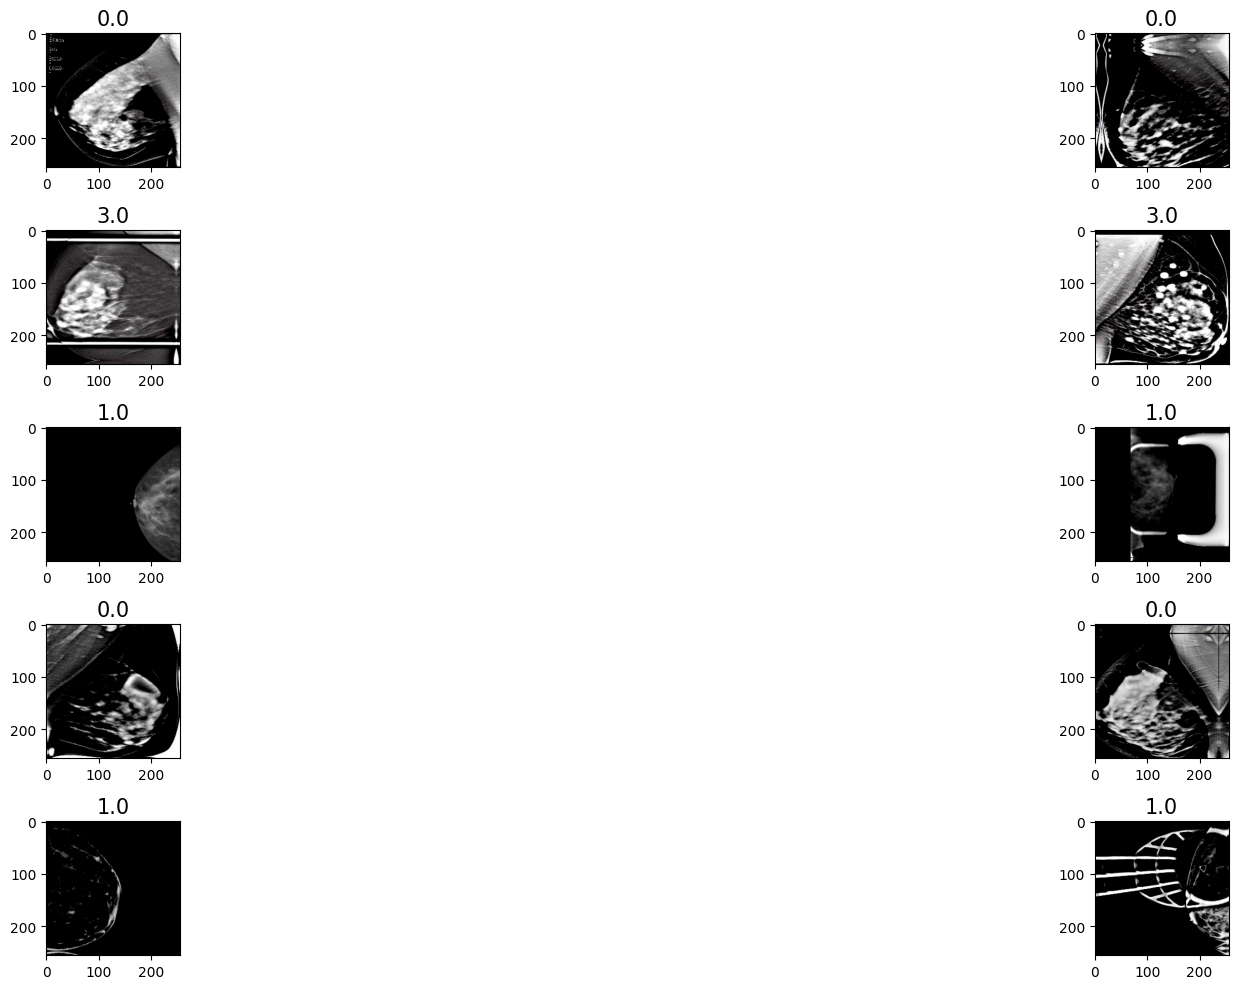

In [30]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,10))

for i in range(5):
    axs[i,0].imshow(dact['images']['img1'][i].numpy().transpose((1,2,0)))
    axs[i,1].imshow(dact['images']['img2'][i].numpy().transpose((1,2,0)))
    axs[i,0].set_title(f"{dact['labels']['label1'][i].item()}", size=15)
    axs[i,1].set_title(f"{dact['labels']['label2'][i].item()}", size=15)

plt.tight_layout()
plt.show()
    

In [31]:
def set_seed(seed : int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [32]:
class Efficient(nn.Module):
    def __init__(self, base_model, num_classes:int=5):
        super(Efficient, self).__init__()
        self.model = base_model
        # self.model = EfficientNet.from_pretrained("efficientnet-b0")
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Linear(1280, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, num_classes),
        )
        
    def forward(self, img):
        x = self.model.extract_features(img)
        x = self.pool(x)
        x = x.view(-1, 1280)
        x = self.classifier(x)
        return x


class EnsembleNet(nn.Module):
    def __init__(self, base_models):
        super().__init__()
        
        self.model_cc = base_models[0]
        self.model_mlo = base_models[1]
        
    def forward(self, images):
        x_cc = self.model_cc(images['img1'])
        x_mlo = self.model_mlo(images['img2'])
                
        prediction = (x_cc + x_mlo) / 2
        return prediction

In [ ]:
from IProcessing_Utils.training_utils import *

## Training

In [39]:
# from torchvision.models import mobilenet_v2
# mobile_v2 = mobilenet_v2(weights="DEFAULT")

# for param in mobile_v2.parameters():
#     if param.requires_grad:
#         param.requires_grad = False

efficientnet = EfficientNet.from_pretrained("efficientnet-b0")

Loaded pretrained weights for efficientnet-b0


In [ ]:
cc_eff, mlo_eff = Efficient(efficientnet, num_classes=4), Efficient(efficientnet, num_classes=4)
model = EnsembleNet([cc_eff, mlo_eff]).to(device)


learning_rate = 1e-4
n_epochs = 20

criterion = torch.nn.CrossEntropyLoss()
# loss = GeneralizedDiceLoss()
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1,verbose=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,patience=3,verbose=True) 

new_model, train_loss, valid_loss, metrics_df = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    loaders, 
    synth_prop=0.5,
    num_epochs=n_epochs,
    num_classes=4
)


In [ ]:
cc_eff, mlo_eff = Efficient(efficientnet, num_classes=4), Efficient(efficientnet, num_classes=4)
model = EnsembleNet([cc_eff, mlo_eff]).to(device)

# Load the checkpoint
checkpoint = torch.load("birads_runs/3classes_0.5/EfficientNet_mammo.pth.tar", map_location=device)

# Load the model weights
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [ ]:
preds, labels = testpreds(model, test_dataloader, device)

In [ ]:
metrics_df = pd.read_csv('birads_runs/3classes_0.5/results.csv')

In [ ]:
# Example usage:
# Assuming metrics_df is the DataFrame returned by train_model
plot_metrics(metrics_df)

In [ ]:
# Calculate metrics and save to CSV
metrics_df = calculate_metrics_save_csv(labels, preds, list(birads_mapping.keys())[:-1], synth_prop=0)

# Plot classification report
plot_classification_report(labels, preds, list(birads_mapping.keys())[:-1])

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, list(birads_mapping.keys())[:-1])